[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

# Mobilenet transfer learning

## Pre-requirements
Training data should be arranged in the following structure:

```
data
-- train
---- class1
------ img1.jpg
------ img2.jpg
---- class2
---- ...
-- val
---- class1
------ img101.jpg
------ img102.jpg
---- class2
---- ...
-- test
---- img201.jpg
---- img202.jpg
---- ...
```

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm

### Check if host machine has GPU available

In [67]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Load Images
#### Apply transforms
Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]. (see these same values used in an official PyTorch example [here](https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101))

In [68]:
data_dir = 'data'


train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Just normalization for validation
test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train = datasets.ImageFolder(data_dir+'/train', transform=train_transforms)
test = datasets.ImageFolder(data_dir+'/val', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(test, batch_size=8, shuffle=True, num_workers=1)

In [69]:
print(len(train), len(test))

287 100


In [70]:
class_mapping = {}
n_classes = 0
for c in train.classes:
    class_mapping[n_classes] = c
    n_classes += 1

print(n_classes)
print(class_mapping)

2
{0: 'humpback', 1: 'southern-right'}


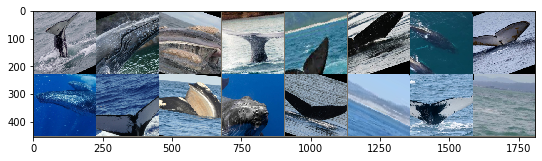

In [71]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.utils.make_grid(inp)
    # in tensor, image is (batch, width, height)
    # so you have to transpose it to (width, height, batch) 
    # in numpy to show it.
    inp = inp.numpy().transpose((1, 2, 0))
    # de-normalise images to get original colours
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(9,9))
    plt.imshow(inp)

# Get a batch of training data
inputs, labels = next(iter(trainloader))
# show images in batch
imshow(inputs)

In [72]:
# load pre-trained mobilenet model
model = models.mobilenet_v2(pretrained=True)

# freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

### Replace the head of the model

In [73]:
# ensure the new head fits onto the existing body
# index added as model.classifier returns list: second index contains in_features
num_ftrs = model.classifier[1].in_features

# define architecture of classifier head
classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=-1)
)

# update the head on pretrained model
model.classifier = classifier

In [74]:
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=.003)

### Training loop

In [75]:
epochs = 5
losses = []
for epoch in range(epochs):
    
    # turns on dropout
    model.train()
    
    batch = 1
    running_loss = 0.0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()  # backprop
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(running_loss / batch)
        batch += 1
    print(f'Epoch {epoch+1} training loss: {running_loss / batch:.3f}')
    
    # VALIDATION AT END OF EPOCH
    # turn off gradients for validation, saves memory and computations
    with torch.no_grad():

        # turn off dropout
        model.eval()
        test_batch = 1
        val_loss = 0.0
        y_true = np.array([])
        y_pred = np.array([])
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to('cpu')
            loss = criterion(outputs, labels.to('cpu'))
            val_loss += loss.item()

            _, batch_predictions = torch.max(outputs.data, 1)
            y_pred = np.hstack((y_pred, batch_predictions.numpy()))
            y_true = np.hstack((y_true, labels.to('cpu').numpy()))
            test_batch += 1

        print(f'Validation accuracy: {100*(y_true == y_pred).mean():.3f}%')

print('Finished Training')

100%|██████████| 18/18 [00:21<00:00,  1.22s/it]

Epoch 1 training loss: 0.661



  0%|          | 0/18 [00:00<?, ?it/s]

Validation accuracy: 80.000%


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

Epoch 2 training loss: 0.430



  0%|          | 0/18 [00:00<?, ?it/s]

Validation accuracy: 97.000%


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]

Epoch 3 training loss: 0.343



  0%|          | 0/18 [00:00<?, ?it/s]

Validation accuracy: 97.000%


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

Epoch 4 training loss: 0.280



  0%|          | 0/18 [00:00<?, ?it/s]

Validation accuracy: 91.000%


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]

Epoch 5 training loss: 0.320


Validation accuracy: 97.000%
Finished Training


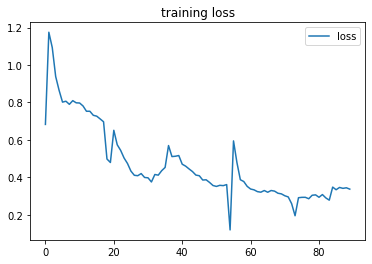

In [76]:
plt.plot(losses, label='loss')
plt.legend()
plt.title('training loss')
plt.show()

### Save model for re-use on other devices

In [77]:
# TODO make model name dynamic
torch.save(model,'./models/mobilenet.pt')

## Sample some test images and show predicted labels
  - TODO: add true labels to plot

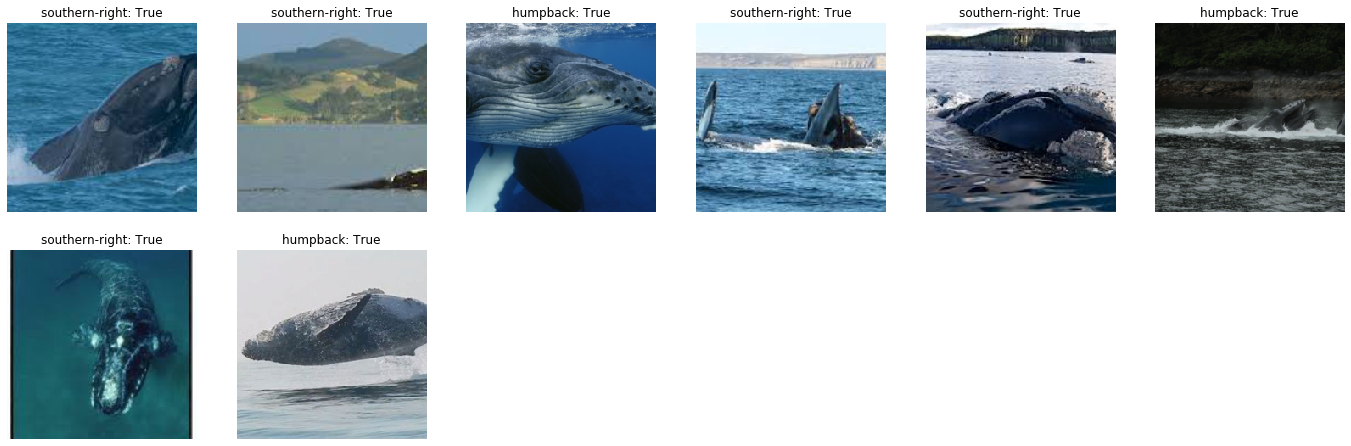

In [78]:
model.eval()

samples, labels = iter(testloader).next()
labels = labels.numpy()
samples = samples.to(device)
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    result = pred[num] == labels[num]
    
    plt.title(class_mapping[pred[num]] + ": " + str(result))
    plt.axis('off')
    sample = sample.cpu().numpy()
    sample = np.transpose(sample, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample = std * sample + mean
    sample = np.clip(sample, 0, 1)
    plt.imshow(sample)

## Detailed accuracy assessment

### Confusion Matrix

In [15]:
confusion_matrix = torch.zeros(n_classes, n_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[50.,  0.],
        [ 7., 43.]])


### Per-Class Accuracy

In [16]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([1.0000, 0.8600])
